In [1]:
from Utils.ConfigProvider import ConfigProvider
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
config = ConfigProvider.config()
%matplotlib inline
%load_ext autoreload
%autoreload 2

Enter config
Leave config


Let’s look at the data


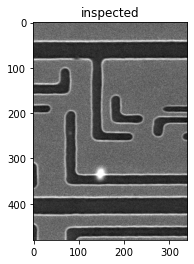

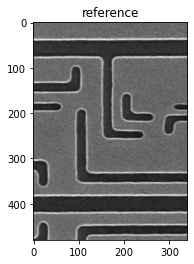

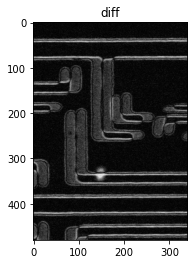

In [14]:
# inspected = cv2.imread(config.data.non_defective_inspected_path, 0)
# reference = cv2.imread(config.data.non_defective_reference_path, 0)
inspected = cv2.imread(config.data.inspected_image_path, 0)
reference = cv2.imread(config.data.reference_image_path, 0)

diff = np.abs(np.array(inspected, dtype=np.int) - np.array(reference, dtype=np.int))

plt.figure()
plt.title('inspected')
plt.imshow(inspected, cmap='gray')
plt.figure()
plt.title('reference')
plt.imshow(reference, cmap='gray')
plt.figure()
plt.title('diff')
plt.imshow(diff, cmap='gray')

plt.show()

Looks like light noise, and some displacement (like we already knew)

Fight the noise:

Enter config
Leave config


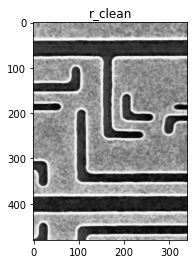

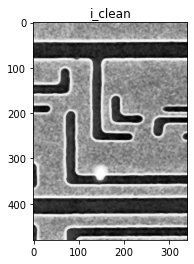

In [15]:
from noise_cleaning.NoiseCleaner import NoiseCleaner
noise_cleaner = NoiseCleaner()
r_clean = reference
i_clean = inspected
# want edge preservation, so no gaussian blur
# r_clean = noise_cleaner.blur(reference)
# i_clean = noise_cleaner.blur(inspected)
r_clean = noise_cleaner.equalize_histogram(r_clean)
i_clean = noise_cleaner.equalize_histogram(i_clean)
r_clean = noise_cleaner.clean_salt_and_pepper(r_clean)
i_clean = noise_cleaner.clean_salt_and_pepper(i_clean)

plt.figure()
plt.title('r_clean')
plt.imshow(r_clean, cmap='gray')
plt.figure()
plt.title('i_clean')
plt.imshow(i_clean, cmap='gray')

Fight the displacement with simple feature based alignment.
(since the images are pretty close and not rotated, area based registration could be better, but less robust)



Enter config
Leave config
forcing tform [[  1.           0.         -24.47491259]
 [  0.           1.           1.96778864]
 [  0.           0.           1.        ]] to translation only
tform: [[  1.           0.         -24.47491259]
 [  0.           1.           1.96778864]
 [  0.           0.           1.        ]]


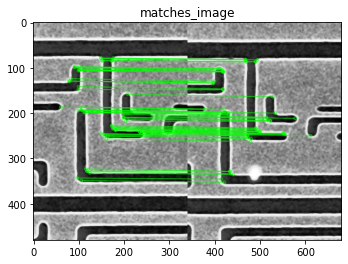

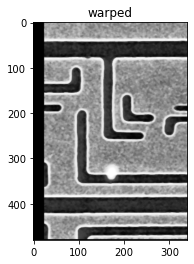

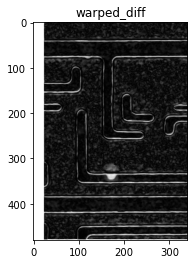

In [16]:
from alignment.Aligner import Aligner
aligner = Aligner()
matches_image, warped, tform, warped_mask = aligner.align_using_feature_matching(static=r_clean, moving=i_clean)
print(f"tform: {tform}")

plt.figure()
plt.title('matches_image')
plt.imshow(matches_image, cmap='gray')
plt.figure()
plt.title('warped')
plt.imshow(warped, cmap='gray')

warped_diff = np.ones(inspected.shape) * 255
warped_diff[warped_mask] = np.array(warped, dtype=np.int)[warped_mask]
warped_diff[warped_mask] -= np.array(r_clean, dtype=np.int)[warped_mask]
warped_diff = np.array(np.abs(warped_diff), dtype=np.uint8)
plt.figure()
plt.title('warped_diff')
plt.imshow(warped_diff, cmap='gray')


By looking at the tform matrix directly, we can see the tform is almost only a translation (good).
We also see that the noise in the (cleaned) images will make a direct subtraction ineffective.

Let's segment the reference image, then apply the segmentaion to the warped image,
and check the probability of each pixel based on its neighbourhood
which is also inside its segment

First, let's see the histogram, to see if thresholding is any good, and which to choose

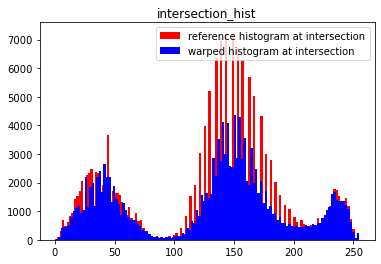

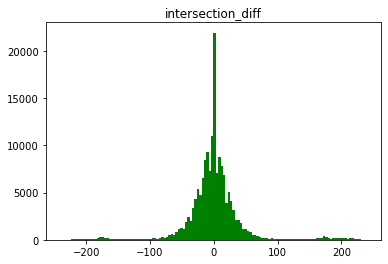

In [17]:
r_intersection = r_clean
r_intersection[~warped_mask] = 0
warped_intersection = warped
warped[~warped_mask] = 0

plt.figure()
plt.title('intersection_hist')
plt.hist(r_clean[warped_mask].ravel(), bins=128, color='red', label='reference histogram at intersection')
plt.hist(warped[warped_mask].ravel(), bins=128, color='blue', label='warped histogram at intersection')
plt.legend()

intersection_diff = np.array(r_intersection, dtype=np.int) - np.array(warped_intersection, dtype=np.int)
plt.figure()
plt.title('intersection_diff')
plt.hist(intersection_diff.ravel(), bins=128, color='green', label='intersection_diff_hist')
plt.show()

We see 3 major clusters of pixels, as can be expected by just looking at the picture:
1. Background.
2. Dark segments.
3. Dark segments' very light borders.

I assume the pixel intensity distribution inside each cluster is Gaussian. Will try to verify or deny that.

Enter config
Leave config
Enter config
Leave config


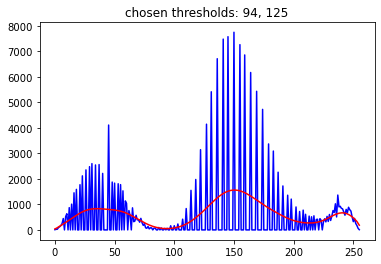

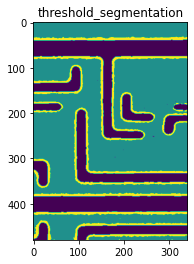

In [24]:
from segmentation.Segmenter import Segmenter
segmenter = Segmenter()
threshold_segmentation, hist, smooth_hist, low_thres, high_thres = segmenter.segment_image_by_threshold(reference)
threshold_segmentation = noise_cleaner.majority(threshold_segmentation, radius=2)

if hist is not None:
    plt.figure()
    plt.title(f"chosen thresholds: {low_thres}, {high_thres}")
    plt.plot(hist, color="blue")
    plt.plot(smooth_hist, color="red")
    plt.show()

plt.figure()
plt.title("threshold_segmentation")
plt.imshow(threshold_segmentation)

Segmentation using thresholds is very noisy, but using a majority vote in each pixel's nhood greatly reduces the noise.

Let's try KMeans

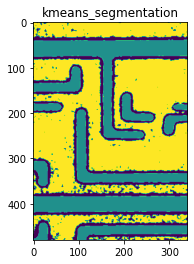

In [27]:
kmeans_segmentation = segmenter.segment_image_by_kmeans(reference)
# kmeans_segmentation = noise_cleaner.majority(kmeans_segmentation, radius=2)

plt.figure()
plt.title("kmeans_segmentation")
plt.imshow(kmeans_segmentation)

Doesn't seem to get the job done without a lot of tweaking.

I will opt for the threshold segmentation method.